In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dependencies

In [ ]:
import os

In [ ]:
data_path = "/content/drive/Othercomputers/New Desktop/ISY5004 media"
video_files = os.path.join(data_path, "videos")

In [ ]:
os.listdir(video_files)

['border_fire.mp4',
 'hughes_fire.mp4',
 'eaton_fire.mp4',
 'palisades_fire_1.mp4',
 'palisades_fire_2.mp4',
 'palisades_fire_3.mp4',
 'palisades_fire_4.mp4',
 'franklin_fire.mp4',
 'mountain_fire.mp4',
 'golden_fire.mp4',
 'glenhaven_fire.mp4',
 'line_fire_1.mp4',
 'line_fire_2.mp4',
 'airport_fire.mp4',
 'line_fire.mp4',
 'crozier_fire.mp4']

In [ ]:
test_video = os.path.join(video_files, 'eaton_fire.mp4')

# Testing optical flow models

In [ ]:
# CV2 optical flow

## opencv Franeback

## Substracting background to better track smoke

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def track_smoke_centriods(video:str):
    cap = cv2.VideoCapture(video)

    # Background subtractor (MOG2 works well)
    fgbg = cv2.createBackgroundSubtractorMOG2(history=500, varThreshold=50, detectShadows=False)

    prev_centroids = []
    frame_count = 0  # Initialize frame counter

    while frame_count < 10:  # Process only 10 frames
        ret, frame = cap.read()
        if not ret:
            break

        # Resize for faster processing
        frame = cv2.resize(frame, (640, 480))

        # Background subtraction
        fgmask = fgbg.apply(frame)

        # Threshold to remove noise
        _, thresh = cv2.threshold(fgmask, 200, 255, cv2.THRESH_BINARY)

        # Morphological operations to clean the mask
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
        clean_mask = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

        # Find contours (potential smoke blobs)
        contours, _ = cv2.findContours(clean_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        curr_centroids = []

        for cnt in contours:
            area = cv2.contourArea(cnt)
            if area > 500:  # filter small blobs
                M = cv2.moments(cnt)
                if M["m00"] == 0:
                    continue
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                curr_centroids.append((cx, cy))

                # Draw contour and centroid
                cv2.drawContours(frame, [cnt], -1, (0, 255, 0), 2)
                cv2.circle(frame, (cx, cy), 5, (0, 0, 255), -1)

        # Track movement from previous to current centroids
        for i, (cx, cy) in enumerate(curr_centroids):
            if i < len(prev_centroids):
                pcx, pcy = prev_centroids[i]
                cv2.arrowedLine(frame, (pcx, pcy), (cx, cy), (255, 0, 0), 2, tipLength=0.5)

        prev_centroids = curr_centroids

        # Print frame number
        print()
        print(f"Frame {frame_count + 1}:")
        print("=" * 12)
        # Display the original frame with tracking
        cv2_imshow(frame)

        # Display the foreground mask
        cv2_imshow(clean_mask)
        if cv2.waitKey(30) & 0xFF == ord('q'):
            break

        frame_count += 1  # Increment frame counter

    cap.release()
    cv2.destroyAllWindows()

In [ ]:
track_smoke_centriods(test_video)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import math

def get_direction(dx, dy):
    angle = math.atan2(-dy, dx) * 180 / np.pi  # -dy because image Y increases downward

    if -45 <= angle <= 45:
        return "RIGHT"
    elif 45 < angle <= 135:
        return "UP"
    elif angle > 135 or angle < -135:
        return "LEFT"
    elif -135 <= angle < -45:
        return "DOWN"
    else:
        return "UNKNOWN"

def track_smoke_centroids_with_direction(video: str):
    cap = cv2.VideoCapture(video)
    fgbg = cv2.createBackgroundSubtractorMOG2(history=500, varThreshold=50, detectShadows=False)

    prev_centroids = []
    frame_count = 0

    while frame_count < 10:
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.resize(frame, (640, 480))
        fgmask = fgbg.apply(frame)
        _, thresh = cv2.threshold(fgmask, 200, 255, cv2.THRESH_BINARY)

        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
        clean_mask = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

        contours, _ = cv2.findContours(clean_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        curr_centroids = []

        for cnt in contours:
            area = cv2.contourArea(cnt)
            if area > 500:
                M = cv2.moments(cnt)
                if M["m00"] == 0:
                    continue
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                curr_centroids.append((cx, cy))
                cv2.drawContours(frame, [cnt], -1, (0, 255, 0), 2)
                cv2.circle(frame, (cx, cy), 5, (0, 0, 255), -1)

        # Compute average movement vector
        dx_total, dy_total, count = 0, 0, 0
        for i, (cx, cy) in enumerate(curr_centroids):
            if i < len(prev_centroids):
                pcx, pcy = prev_centroids[i]
                dx, dy = cx - pcx, cy - pcy
                dx_total += dx
                dy_total += dy
                count += 1
                cv2.arrowedLine(frame, (pcx, pcy), (cx, cy), (255, 0, 0), 2, tipLength=0.5)

        direction = "NO MOVEMENT"
        if count > 0:
            avg_dx = dx_total / count
            avg_dy = dy_total / count
            direction = get_direction(avg_dx, avg_dy)

        print()
        print(f"Frame {frame_count + 1}:")
        print("=" * 12)
        print(f"Smoke direction: {direction}")

        if cv2.waitKey(30) & 0xFF == ord('q'):
            break

        prev_centroids = curr_centroids
        frame_count += 1

    cap.release()
    cv2.destroyAllWindows()


In [ ]:
track_smoke_centroids_with_direction(test_video)


Frame 1:
Smoke direction: NO MOVEMENT

Frame 2:
Smoke direction: LEFT

Frame 3:
Smoke direction: LEFT

Frame 4:
Smoke direction: UP

Frame 5:
Smoke direction: DOWN

Frame 6:
Smoke direction: UP

Frame 7:
Smoke direction: UP

Frame 8:
Smoke direction: UP

Frame 9:
Smoke direction: DOWN

Frame 10:
Smoke direction: LEFT


## RAFT

### Installation

In [ ]:
# https://github.com/pytorch/vision/blob/main/torchvision/models/optical_flow/raft.py

In [ ]:
!pip install flow-vis

In [ ]:
import torch
import torchvision.transforms.functional as TF
import torchvision.models.optical_flow as optical_flow
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import flow_vis

In [ ]:
def load_and_resize_tensor(frame, size=(320, 448)):
    tensor = TF.to_tensor(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    return TF.resize(tensor, size)[None]  # Add batch dim

def flow_to_rgb(flow):
    return flow_vis.flow_to_color(flow, convert_to_bgr=False)

def show_optical_flow_raft(video_path: str, num_frames: int = 10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load RAFT model
    raft = optical_flow.raft_small(pretrained=True).eval().to(device)

    cap = cv2.VideoCapture(video_path)
    prev_tensor = None
    prev_frame_raw = None
    frame_count = 0

    while frame_count < num_frames:
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.resize(frame, (640, 480))
        tensor = load_and_resize_tensor(frame).to(device)

        if prev_tensor is not None:
            with torch.no_grad():
                flow = raft(prev_tensor, tensor)[-1]  # output: (1, 2, H, W)

            flow_np = flow[0].permute(1, 2, 0).cpu().numpy()  # shape: (H, W, 2)
            flow_rgb = flow_to_rgb(flow_np)
            flow_rgb = cv2.resize((flow_rgb * 255).astype(np.uint8), (640, 480))

            print(f"Frame {frame_count + 1}")
            cv2_imshow(flow_rgb)

        prev_tensor = tensor
        prev_frame_raw = frame
        frame_count += 1

    cap.release()
    cv2.destroyAllWindows()


### RAFT testing

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Raft_Small_Weights.C_T_V2`. You can also use `weights=Raft_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Frame 2


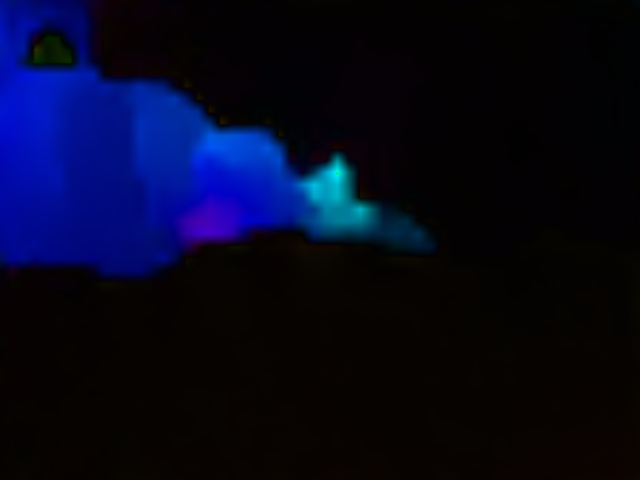

Frame 3


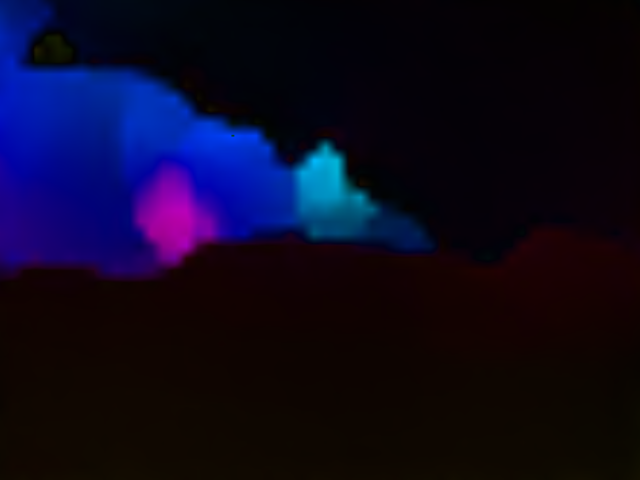

Frame 4


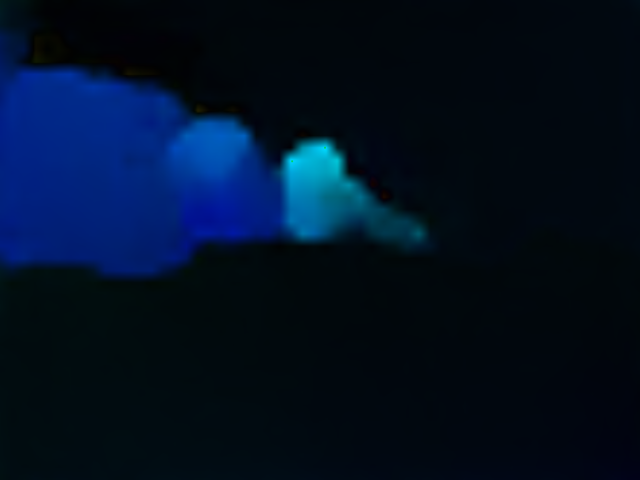

Frame 5


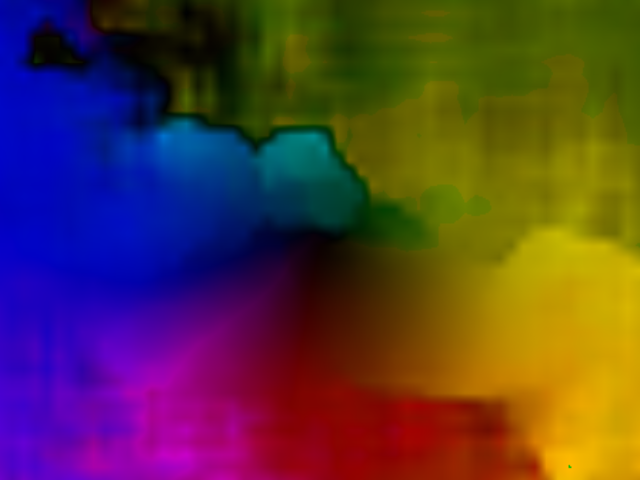

Frame 6


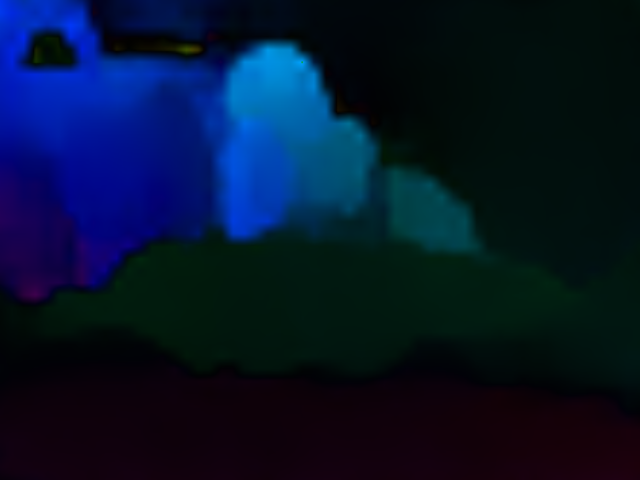

Frame 7


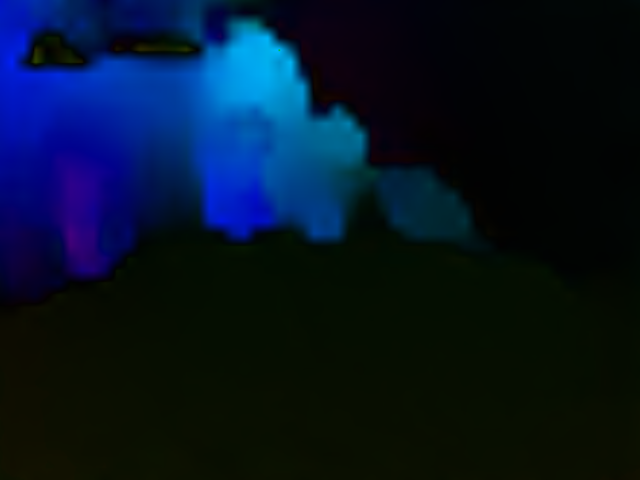

Frame 8


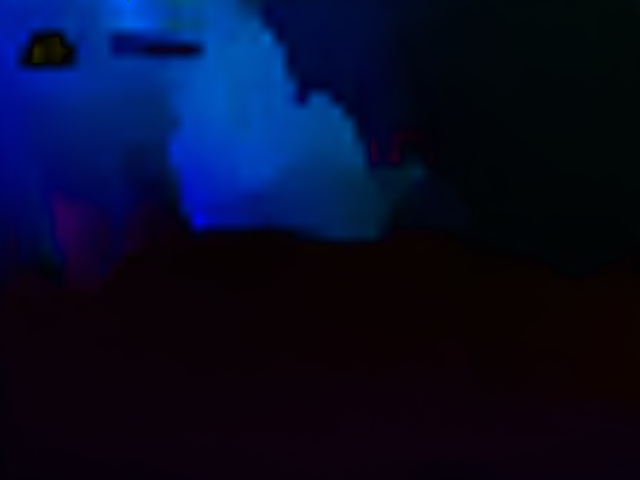

Frame 9


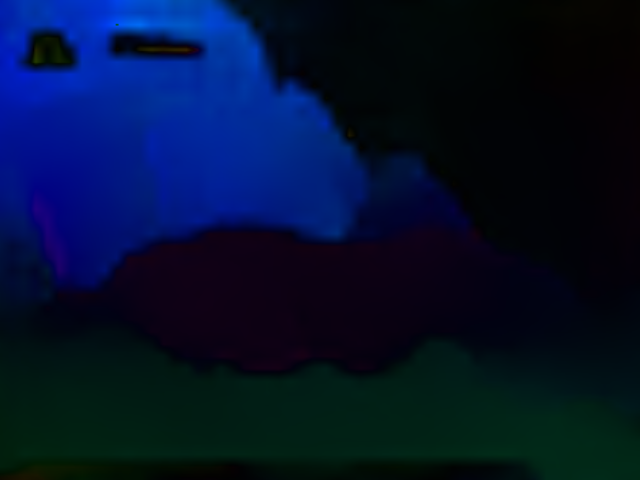

Frame 10


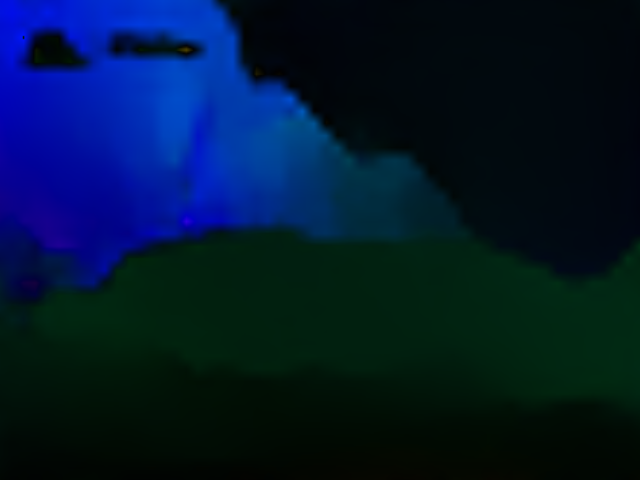

In [ ]:
show_optical_flow_raft(test_video)

In [ ]:
import torch
import torchvision.transforms.functional as TF
import torchvision.models.optical_flow as optical_flow
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def draw_flow_arrows(flow, step=20, scale=5):
    h, w, _ = flow.shape
    vis = np.zeros((h, w, 3), dtype=np.uint8)

    for y in range(0, h, step):
        for x in range(0, w, step):
            dx, dy = flow[y, x]
            end_x = int(x + dx * scale)
            end_y = int(y + dy * scale)
            cv2.arrowedLine(vis, (x, y), (end_x, end_y), (255, 255, 255), 1, tipLength=0.3)

    return vis

def show_optical_flow_raft_arrows(video_path: str, num_frames: int = 10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    raft = optical_flow.raft_small(pretrained=True).eval().to(device)

    cap = cv2.VideoCapture(video_path)
    prev_tensor = None
    prev_frame_raw = None
    frame_count = 0

    while frame_count < num_frames:
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.resize(frame, (640, 480))
        tensor = load_and_resize_tensor(frame).to(device)

        if prev_tensor is not None:
            with torch.no_grad():
                flow = raft(prev_tensor, tensor)[-1]  # (1, 2, H, W)

            flow_np = flow[0].permute(1, 2, 0).cpu().numpy()  # (H, W, 2)
            flow_vis_arrows = draw_flow_arrows(flow_np, step=20, scale=5)

            print(f"Frame {frame_count + 1}")
            cv2_imshow(flow_vis_arrows)

        prev_tensor = tensor
        prev_frame_raw = frame
        frame_count += 1

    cap.release()
    cv2.destroyAllWindows()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Raft_Small_Weights.C_T_V2`. You can also use `weights=Raft_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Frame 2


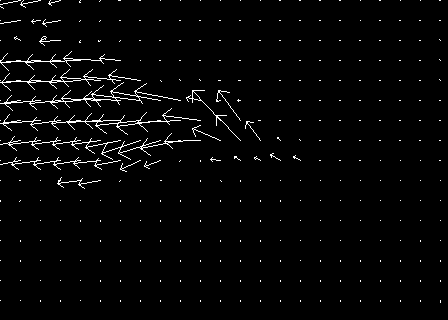

Frame 3


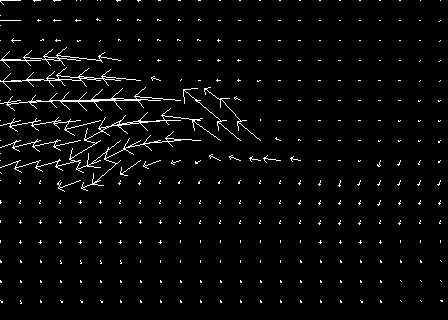

Frame 4


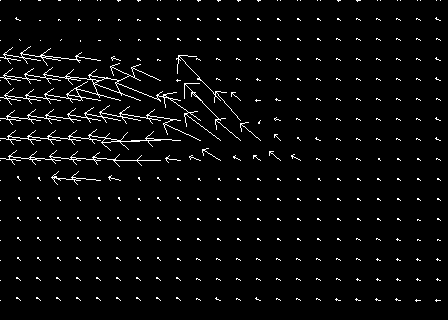

Frame 5


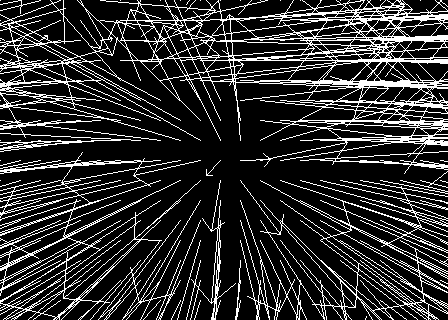

Frame 6


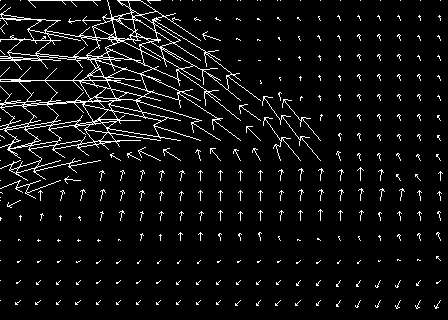

Frame 7


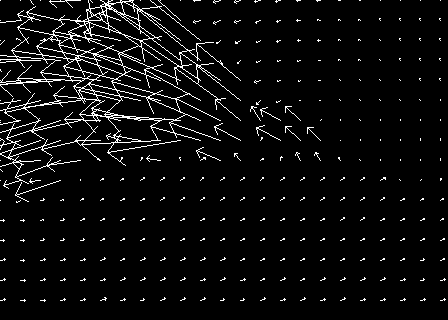

Frame 8


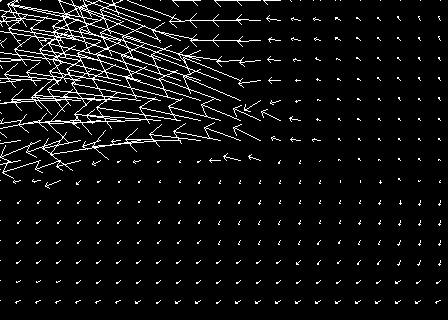

Frame 9


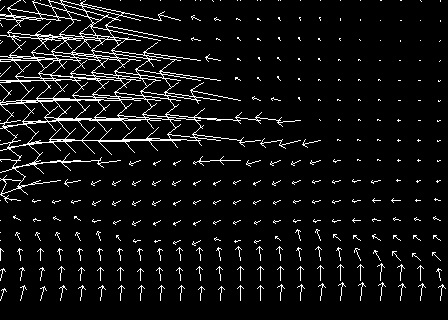

Frame 10


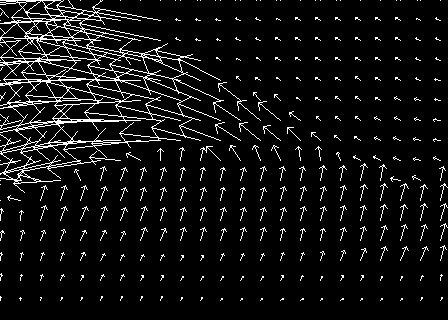

In [ ]:
show_optical_flow_raft_arrows(test_video)

In [ ]:
import torch
import torchvision.transforms.functional as TF
import torchvision.models.optical_flow as optical_flow
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def load_and_resize_tensor(frame, size=(320, 448)):
    tensor = TF.to_tensor(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    return TF.resize(tensor, size)[None]  # Add batch dim

def draw_flow_arrows_on_frame(flow, frame, step=20, scale=5):
    h, w, _ = flow.shape
    vis = frame.copy()  # use the original frame as the base

    for y in range(0, h, step):
        for x in range(0, w, step):
            dx, dy = flow[y, x]
            end_x = int(x + dx * scale)
            end_y = int(y + dy * scale)
            cv2.arrowedLine(vis, (x, y), (end_x, end_y), (0, 255, 0), 1, tipLength=0.3)  # green arrows

    return vis

def show_optical_flow_raft_arrows(video_path: str, num_frames: int = 10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    raft = optical_flow.raft_small(pretrained=True).eval().to(device)

    cap = cv2.VideoCapture(video_path)
    prev_tensor = None
    prev_frame_raw = None
    frame_count = 0

    while frame_count < num_frames:
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.resize(frame, (640, 480))
        tensor = load_and_resize_tensor(frame).to(device)

        if prev_tensor is not None:
            with torch.no_grad():
                flow = raft(prev_tensor, tensor)[-1]  # (1, 2, H, W)

            flow_np = flow[0].permute(1, 2, 0).cpu().numpy()  # (H, W, 2)
            flow_vis_frame = draw_flow_arrows_on_frame(flow_np, frame, step=20, scale=5)

            print(f"Frame {frame_count + 1}")
            cv2_imshow(flow_vis_frame)

        prev_tensor = tensor
        prev_frame_raw = frame
        frame_count += 1

    cap.release()
    cv2.destroyAllWindows()


In [ ]:
show_optical_flow_raft_arrows(test_video)

Output hidden; open in https://colab.research.google.com to view.

#### Low light testing

In [ ]:
low_light = os.path.join(video_files, 'franklin_fire.mp4')

Using device: cpu


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Raft_Small_Weights.C_T_V2`. You can also use `weights=Raft_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Frame 2


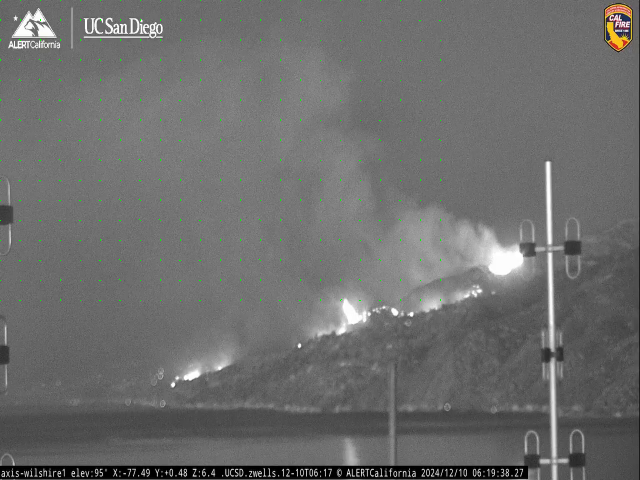

Frame 3


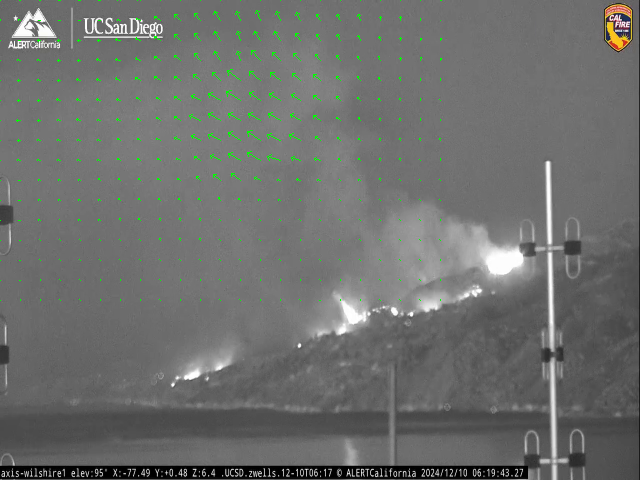

Frame 4


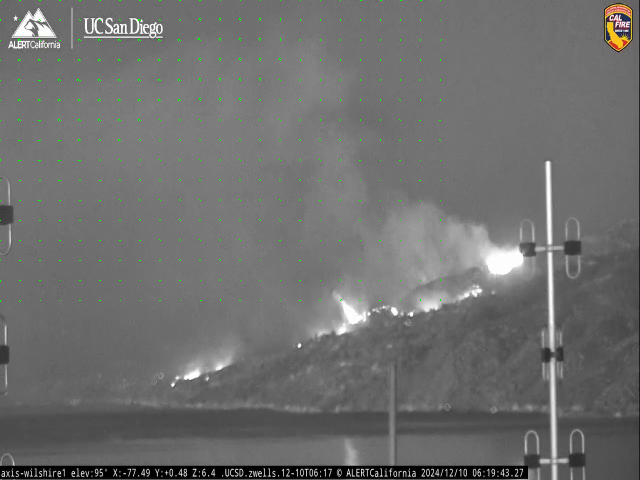

Frame 5


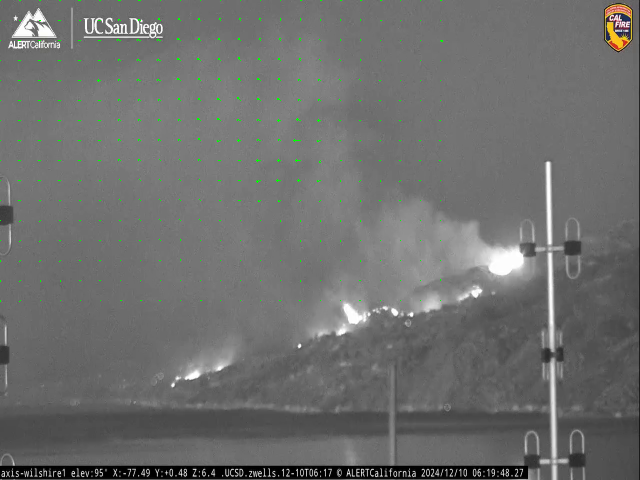

In [ ]:
show_optical_flow_raft_arrows(low_light, 5)

#### Different smoke direction

In [ ]:
# Testing RAFT on different smoke direction (Upwards and Downwards)

In [ ]:
smoke_downwards = os.path.join(video_files, 'line_fire_3.mp4')

Using device: cpu


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Raft_Small_Weights.C_T_V2`. You can also use `weights=Raft_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Frame 2


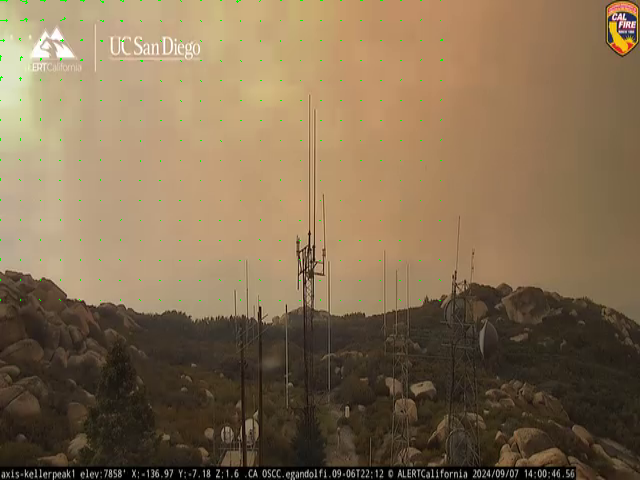

Frame 3


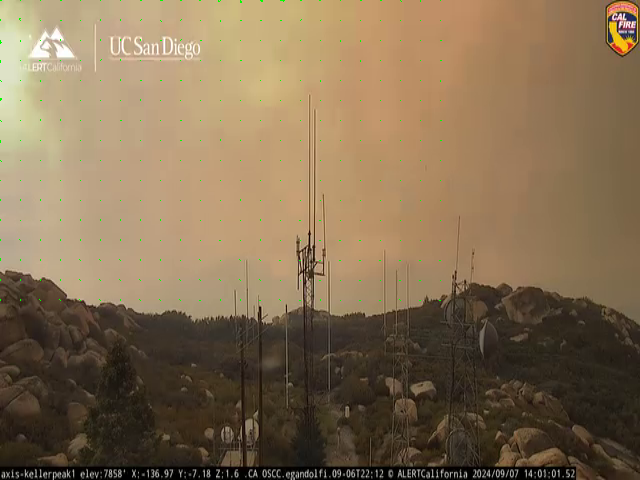

Frame 4


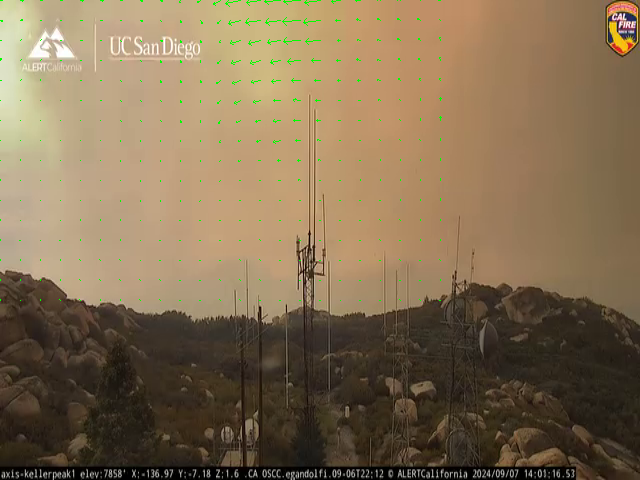

Frame 5


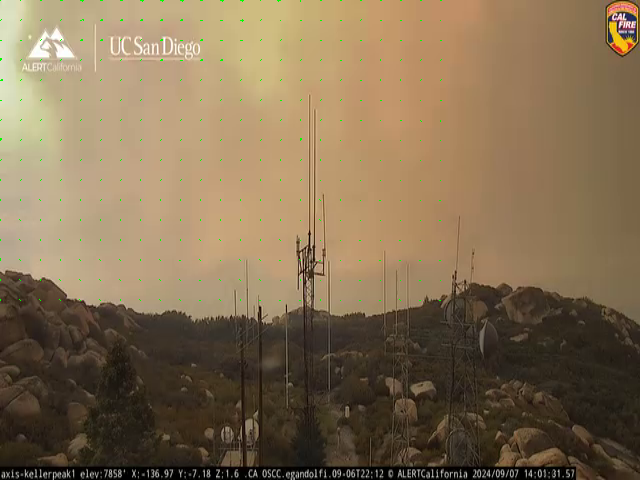

In [ ]:
show_optical_flow_raft_arrows(smoke_downwards, 5)

## MiDas (Depth Estimation)

In [ ]:
import torch
import torchvision.transforms as T
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

def load_midas_model(device):
    midas = torch.hub.load("intel-isl/MiDaS", "MiDaS_small")
    midas.to(device).eval()
    transform = torch.hub.load("intel-isl/MiDaS", "transforms").small_transform
    return midas, transform

def show_depth_midas(video_path: str, num_frames: int = 10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    midas, transform = load_midas_model(device)

    cap = cv2.VideoCapture(video_path)
    frame_count = 0

    while frame_count < num_frames:
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.resize(frame, (640, 480))
        input_batch = transform(frame).to(device)

        with torch.no_grad():
            prediction = midas(input_batch)
            prediction = torch.nn.functional.interpolate(
                prediction.unsqueeze(1),
                size=frame.shape[:2],
                mode="bicubic",
                align_corners=False,
            ).squeeze()

        depth_map = prediction.cpu().numpy()
        depth_map_normalized = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX)
        depth_colored = cv2.applyColorMap(depth_map_normalized.astype(np.uint8), cv2.COLORMAP_INFERNO)

        print(f"Frame {frame_count + 1}")
        cv2_imshow(depth_colored)

        frame_count += 1

    cap.release()
    cv2.destroyAllWindows()


Using device: cpu


/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.l

Loading weights:  None


/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/rwightman/gen-efficientnet-pytorch/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_lite3-b733e338.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_lite3-b733e338.pth
Downloading: "https://github.

Frame 1


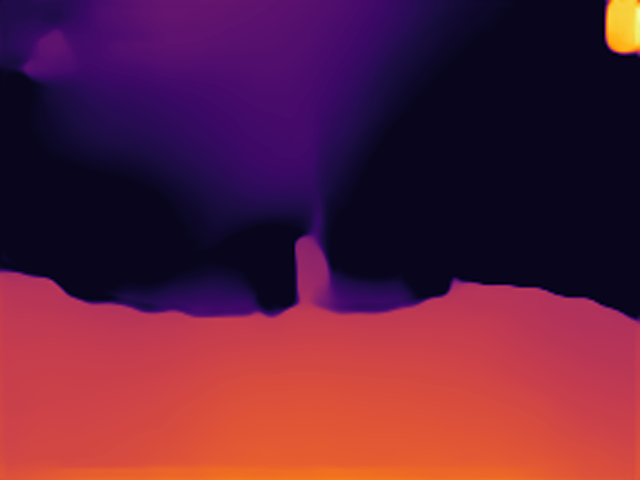

Frame 2


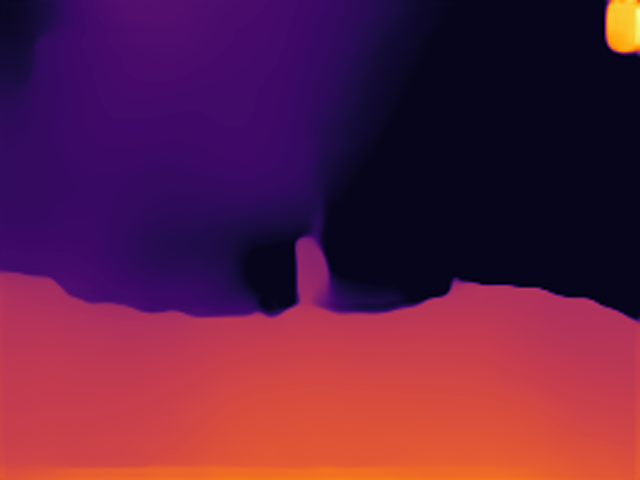

Frame 3


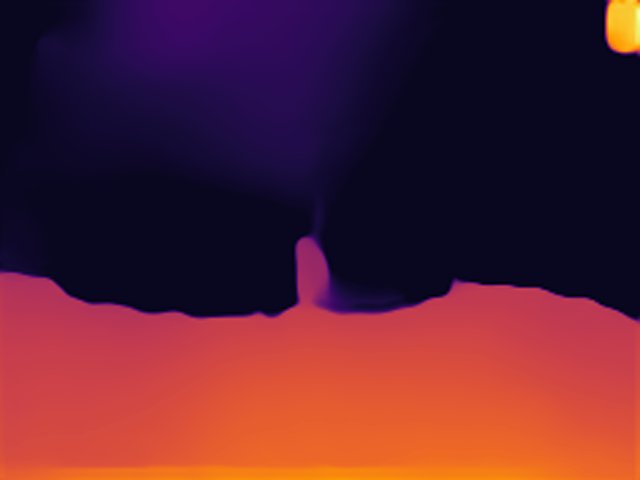

Frame 4


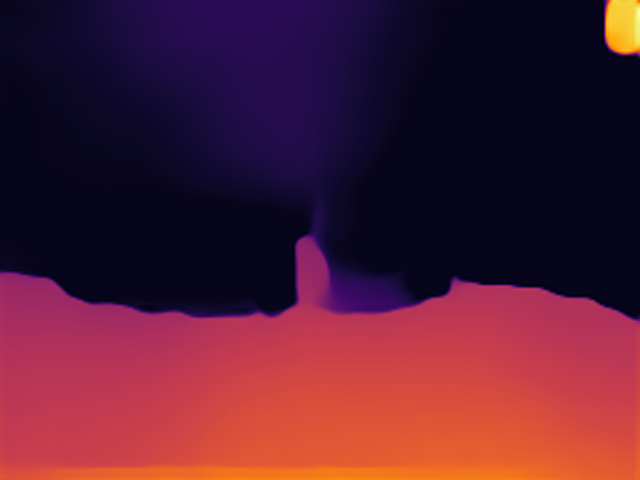

Frame 5


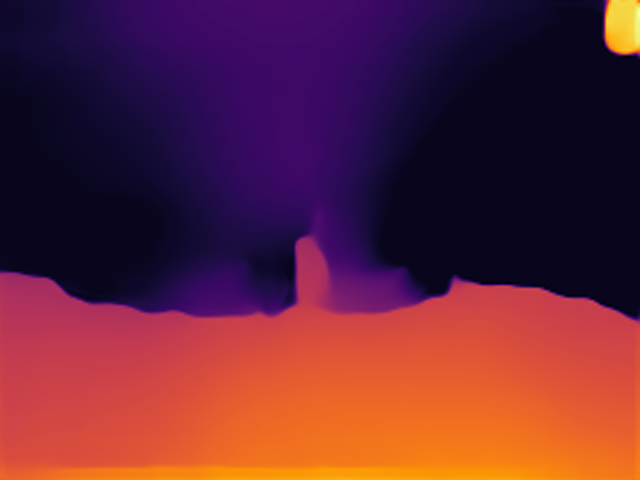

In [ ]:
show_depth_midas(smoke_downwards, 5)

In [ ]:
def get_depth_map_from_frame(frame, midas, transform, device):
    input_batch = transform(frame).to(device)
    with torch.no_grad():
        prediction = midas(input_batch)
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=frame.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()
    return prediction.cpu().numpy()

def compare_midas_depth_between_frames(video_path: str, frame_idx1: int, frame_idx2: int, roi_coords=(100, 300, 150, 500)):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    midas, transform = load_midas_model(device)

    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if frame_idx1 >= total_frames or frame_idx2 >= total_frames:
        print("Frame index exceeds video length.")
        return

    def get_frame_by_index(index):
        cap.set(cv2.CAP_PROP_POS_FRAMES, index)
        ret, frame = cap.read()
        return cv2.resize(frame, (640, 480)) if ret else None

    frame1 = get_frame_by_index(frame_idx1)
    frame2 = get_frame_by_index(frame_idx2)

    if frame1 is None or frame2 is None:
        print("Error reading one of the frames.")
        return

    depth1 = get_depth_map_from_frame(frame1, midas, transform, device)
    depth2 = get_depth_map_from_frame(frame2, midas, transform, device)

    y1, y2, x1, x2 = roi_coords
    mean_depth1 = np.mean(depth1[y1:y2, x1:x2])
    mean_depth2 = np.mean(depth2[y1:y2, x1:x2])

    # Display the depth maps using matplotlib
    def show_depth_map(depth, title):
        norm_depth = cv2.normalize(depth, None, 0, 255, cv2.NORM_MINMAX)
        color_map = cv2.applyColorMap(norm_depth.astype(np.uint8), cv2.COLORMAP_INFERNO)
        plt.imshow(cv2.cvtColor(color_map, cv2.COLOR_BGR2RGB))
        plt.title(title)
        plt.axis('off')

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    show_depth_map(depth1, f"Depth at Frame {frame_idx1}")
    plt.subplot(1, 2, 2)
    show_depth_map(depth2, f"Depth at Frame {frame_idx2}")
    plt.show()

    print(f"Mean depth in ROI (Frame {frame_idx1}): {mean_depth1:.4f}")
    print(f"Mean depth in ROI (Frame {frame_idx2}): {mean_depth2:.4f}")
    print(f"Depth change: {mean_depth2 - mean_depth1:.4f}")

    if mean_depth2 < mean_depth1:
        print("Smoke is getting closer (moving towards camera).")
    else:
        print("Smoke is moving away.")

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


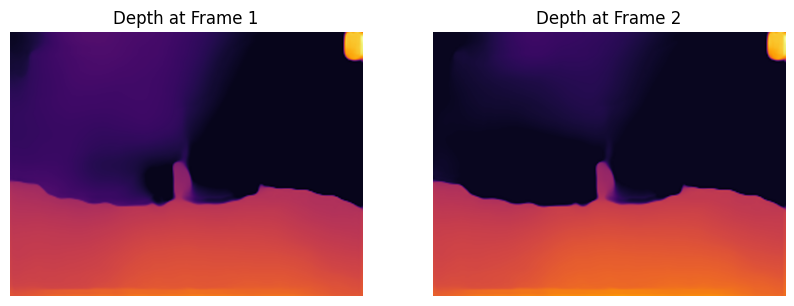

Mean depth in ROI (Frame 1): 49.3575
Mean depth in ROI (Frame 2): 20.2770
Depth change: -29.0805
Smoke is getting closer (moving towards camera).


In [ ]:
compare_midas_depth_between_frames(smoke_downwards,1,2)

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


Loading weights:  None


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


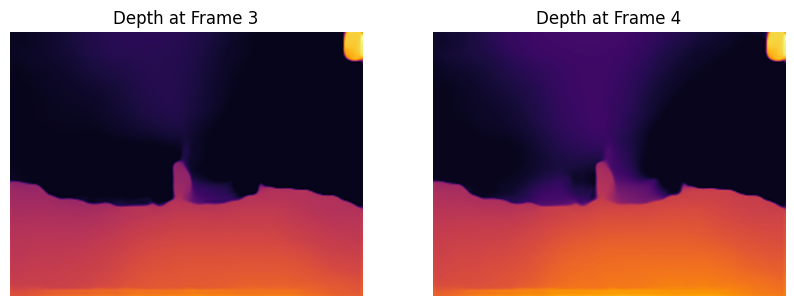

Mean depth in ROI (Frame 3): 24.5611
Mean depth in ROI (Frame 4): 51.2288
Depth change: 26.6677
Smoke is moving away.


In [ ]:
compare_midas_depth_between_frames(smoke_downwards,3,4)

In [ ]:
smoke_downwards_2 = os.path.join(video_files, 'palisades_fire_1.mp4')

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


Loading weights:  None


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


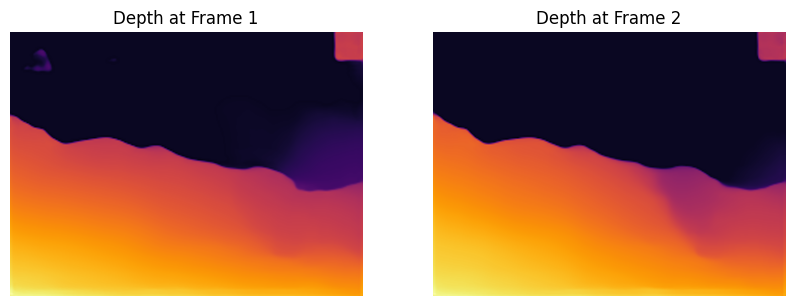

Mean depth in ROI (Frame 1): 157.3041
Mean depth in ROI (Frame 2): 167.2763
Depth change: 9.9723
Smoke is moving away.


In [ ]:
compare_midas_depth_between_frames(smoke_downwards_2,1,2)